# DATA EDA 분석 1. (2020.11.25(수))

* 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, SpatialDropout1D, Activation, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ReLU, PReLU, LeakyReLU, ELU
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from tensorflow.keras.utils import plot_model

 * 데이터 불러오기

In [2]:
# 1. 온라인 행동 데이터
raw_data1_Online_Act = pd.read_csv('./data/data1_Online_Act.csv')

# 2. 거래 정보 데이터
raw_data2_Trade_Inform = pd.read_csv('./data/data2_Trade_Inform.csv')

# 3. 사용자 demo 정보(나이, 성별)
raw_data3_Demog = pd.read_csv('./data/data3_Demog.csv')

# 4. 상품 대중소 분류 정보
raw_data4_Item_Class = pd.read_csv('./data/data4_Item_Class.csv')

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 1. 온라인 행동 데이터 확인

In [3]:
raw_data1_Online_Act.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,7809,1,8,5,A03,20190913,01:16,2571103,NaN,NaN,34.0,2663.0,DIRECT,NaN
1,7809,1,4,2,A03,20190913,01:14,2485909,NaN,NaN,34.0,2663.0,DIRECT,NaN
2,7809,1,11,5,A03,20190913,01:17,2646597,NaN,NaN,34.0,2663.0,DIRECT,NaN
3,7809,1,1,2,A03,20190913,00:46,788304,NaN,NaN,34.0,2663.0,DIRECT,NaN
4,7809,1,9,5,A03,20190913,01:17,2617609,NaN,NaN,34.0,2663.0,DIRECT,NaN


* 1-1. clnt_id : 고객 고유 식별 ID
* 1-2. sess_id : 세션이 시작될 때 부여되는 순번ID
* 1-3. hit_seq : 조회 순서를 알 수 있도록 한 일련번호
* 1-4. action_type : 온라인 행동 유형
 (0:검색 / 1:제품 목록 / 2:제품 세부정보 보기 / 3: 장바구니 제품 추가 / 4:장바구니 제품 삭제 / 5:결제 시도 / 6:구매완료 / 7:구매환불 / 8:결재 옵션)
* 1-5. biz_unit(업종단위) : 온라인 및 오프라인 이용코드
* 1-6. sess_dt : 세션 일자(년월일)
* 1-7. hit_tm : 조회 시각(HH:MM)
* 1-8. hit_pss_tm : 조회 경과시간(세션의 시작 부터 조회까지 걸리시간(밀리초) / 첫번째 조회는 0으로 설정)
* 1-9. Trans_ID : 거래 ID(구매내역을 고유 식별할 수 있는 ID)
* 1-10. sech_kwd : 고객이 검색한 키워드
* 1-11. tot_pag_view_ct : 총 페이지 조회 건수(세션 내에 총 페이지(화면) 뷰 수)
* 1-12. tot_sess_hr_v : 총 세션 시간 값
* 1-13. trfc_src : 유입 채널
 (DIRECT / PUSH / WEBSITE / PORTAL_1 / PORTAL_2 / PORTAL_3 / unknown)
* 1-14. dvc_ctg_nm : 기기 유형 (mobile_web / mobile_app / PC)

In [4]:
raw_data1_Online_Act.shape

(3196362, 14)

 * 행 수(데이터 갯수) : 319만 개
 * 열 수(데이터 종류) : 14개

* 데이터를 - clnt_id -> sess_id -> sess_dt(일자) -> hit_tm(시분) -> hit_pss_tm(밀리초) 순으로 정렬(시간순 정렬)
    * 같은 고객ID와 세션_id를 가지고, 같은 일자 비슷한 시점의 온라인 행동은 같은 품목에 의해서 수행되었을 것이다 가정

In [5]:
raw1_sorted_time = raw_data1_Online_Act.sort_values(by = ['clnt_id', 'sess_id', 'sess_dt', 'hit_tm', 'hit_pss_tm'], axis=0)
raw1_sorted_time.head(50)

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
3102890,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app
3136925,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app
3065714,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app
3091872,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app
3142610,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app
3084082,1,2,3,0,A01,20190922,14:10,70025,NaN,초등남아옷,45.0,424.0,unknown,mobile_app
3136926,1,2,4,0,A01,20190922,14:11,119527,NaN,초등남아점퍼,45.0,424.0,unknown,mobile_app
3123796,1,2,5,0,A01,20190922,14:11,162327,NaN,노스페이스키즈,45.0,424.0,unknown,mobile_app
3001880,1,2,6,0,A01,20190922,14:12,178832,NaN,노스페이스초등,45.0,424.0,unknown,mobile_app
3142609,1,2,7,0,A01,20190922,14:12,192367,NaN,노스페이스키즈,45.0,424.0,unknown,mobile_app


 * 온라인 행동에 대한 키워드 추가

In [6]:
raw1_sorted_time['act_kwd'] = raw1_sorted_time['sech_kwd']

In [7]:
raw1_sorted_time.head(20)

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,act_kwd
3102890,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app,과일선물세트
3136925,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app,과일선물세트 백화점
3065714,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app,과일바구니
3091872,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app,초등가을잠바
3142610,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app,초등가을점퍼
3084082,1,2,3,0,A01,20190922,14:10,70025,NaN,초등남아옷,45.0,424.0,unknown,mobile_app,초등남아옷
3136926,1,2,4,0,A01,20190922,14:11,119527,NaN,초등남아점퍼,45.0,424.0,unknown,mobile_app,초등남아점퍼
3123796,1,2,5,0,A01,20190922,14:11,162327,NaN,노스페이스키즈,45.0,424.0,unknown,mobile_app,노스페이스키즈
3001880,1,2,6,0,A01,20190922,14:12,178832,NaN,노스페이스초등,45.0,424.0,unknown,mobile_app,노스페이스초등
3142609,1,2,7,0,A01,20190922,14:12,192367,NaN,노스페이스키즈,45.0,424.0,unknown,mobile_app,노스페이스키즈


 * index_reset

In [8]:
raw1_sorted_time = raw1_sorted_time.reset_index()

In [9]:
# 기존 인덱스인 Index열 삭제
raw1_sorted_time = raw1_sorted_time.drop(['index'], axis=1)

In [10]:
raw1_sorted_time.head(20)

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,act_kwd
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app,과일선물세트
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app,과일선물세트 백화점
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app,과일바구니
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app,초등가을잠바
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app,초등가을점퍼
5,1,2,3,0,A01,20190922,14:10,70025,NaN,초등남아옷,45.0,424.0,unknown,mobile_app,초등남아옷
6,1,2,4,0,A01,20190922,14:11,119527,NaN,초등남아점퍼,45.0,424.0,unknown,mobile_app,초등남아점퍼
7,1,2,5,0,A01,20190922,14:11,162327,NaN,노스페이스키즈,45.0,424.0,unknown,mobile_app,노스페이스키즈
8,1,2,6,0,A01,20190922,14:12,178832,NaN,노스페이스초등,45.0,424.0,unknown,mobile_app,노스페이스초등
9,1,2,7,0,A01,20190922,14:12,192367,NaN,노스페이스키즈,45.0,424.0,unknown,mobile_app,노스페이스키즈


In [ ]:
# raw1_sorted_time = raw1_sorted_time[:10000]

In [224]:
# # 잠시 주석처리
# raw1_sorted_time['act_kwd'] = [raw1_sorted_time['act_kwd'].loc[s] if type(raw1_sorted_time['act_kwd'].loc[s]) == str 
#                                else (raw1_sorted_time['act_kwd'].loc[s-1] if raw1_sorted_time['clnt_id'].loc[s] == raw1_sorted_time['clnt_id'].loc[s-1] 
#                                      and raw1_sorted_time['sess_id'].loc[s] == raw1_sorted_time['sess_id'].loc[s-1] 
#                                      and raw1_sorted_time['biz_unit'].loc[s] == raw1_sorted_time['biz_unit'].loc[s-1] 
#                                      and raw1_sorted_time['hit_pss_tm'].loc[s]-raw1_sorted_time['hit_pss_tm'].loc[s-1] <= 180000 
#                                      else 'bsd') for s in range(len(raw1_sorted_time['act_kwd']))]

# raw1_sorted_time.head(20)

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,act_kwd
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app,과일선물세트
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app,과일선물세트 백화점
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app,과일바구니
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app,초등가을잠바
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app,초등가을점퍼
5,1,2,3,0,A01,20190922,14:10,70025,NaN,초등남아옷,45.0,424.0,unknown,mobile_app,초등남아옷
6,1,2,4,0,A01,20190922,14:11,119527,NaN,초등남아점퍼,45.0,424.0,unknown,mobile_app,초등남아점퍼
7,1,2,5,0,A01,20190922,14:11,162327,NaN,노스페이스키즈,45.0,424.0,unknown,mobile_app,노스페이스키즈
8,1,2,6,0,A01,20190922,14:12,178832,NaN,노스페이스초등,45.0,424.0,unknown,mobile_app,노스페이스초등
9,1,2,7,0,A01,20190922,14:12,192367,NaN,노스페이스키즈,45.0,424.0,unknown,mobile_app,노스페이스키즈


In [225]:
# # 잠시 주석처리
# # 한번 더!
# raw1_sorted_time['act_kwd'] = [raw1_sorted_time['act_kwd'].loc[s] if type(raw1_sorted_time['act_kwd'].loc[s]) == str 
#                                else (raw1_sorted_time['act_kwd'].loc[s-1] if raw1_sorted_time['clnt_id'].loc[s] == raw1_sorted_time['clnt_id'].loc[s-1] 
#                                      and raw1_sorted_time['sess_id'].loc[s] == raw1_sorted_time['sess_id'].loc[s-1] 
#                                      and raw1_sorted_time['biz_unit'].loc[s] == raw1_sorted_time['biz_unit'].loc[s-1] 
#                                      and raw1_sorted_time['hit_pss_tm'].loc[s]-raw1_sorted_time['hit_pss_tm'].loc[s-1] <= 180000 
#                                      else 'bsd') for s in range(len(raw1_sorted_time['act_kwd']))]

# raw1_sorted_time.head(20)

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,act_kwd
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app,과일선물세트
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app,과일선물세트 백화점
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app,과일바구니
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app,초등가을잠바
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app,초등가을점퍼
5,1,2,3,0,A01,20190922,14:10,70025,NaN,초등남아옷,45.0,424.0,unknown,mobile_app,초등남아옷
6,1,2,4,0,A01,20190922,14:11,119527,NaN,초등남아점퍼,45.0,424.0,unknown,mobile_app,초등남아점퍼
7,1,2,5,0,A01,20190922,14:11,162327,NaN,노스페이스키즈,45.0,424.0,unknown,mobile_app,노스페이스키즈
8,1,2,6,0,A01,20190922,14:12,178832,NaN,노스페이스초등,45.0,424.0,unknown,mobile_app,노스페이스초등
9,1,2,7,0,A01,20190922,14:12,192367,NaN,노스페이스키즈,45.0,424.0,unknown,mobile_app,노스페이스키즈


In [229]:
raw1_sorted_time.loc[100:150]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,act_kwd
100,2,8,23,0,A03,20190731,20:38,437380,NaN,팥,85.0,3256.0,DIRECT,NaN,팥
101,2,8,24,0,A03,20190731,20:38,444324,NaN,팥빙수팥,85.0,3256.0,DIRECT,NaN,팥빙수팥
102,2,8,25,1,A03,20190731,20:39,447238,NaN,NaN,85.0,3256.0,DIRECT,NaN,팥빙수팥
103,2,8,26,2,A03,20190731,20:39,449080,NaN,NaN,85.0,3256.0,DIRECT,NaN,팥빙수팥
104,2,8,27,3,A03,20190731,20:41,608281,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN
105,2,8,28,5,A03,20190731,20:41,610918,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN
106,2,8,29,5,A03,20190731,20:41,616663,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN
107,2,8,30,1,A03,20190731,20:42,673120,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN
108,2,8,31,2,A03,20190731,20:42,674451,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN
109,2,8,32,3,A03,20190731,20:44,806007,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN


In [247]:
raw1_sorted_time.loc[100:107]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,act_kwd
100,2,8,23,0,A03,20190731,20:38,437380,NaN,팥,85.0,3256.0,DIRECT,NaN,팥
101,2,8,24,0,A03,20190731,20:38,444324,NaN,팥빙수팥,85.0,3256.0,DIRECT,NaN,팥빙수팥
102,2,8,25,1,A03,20190731,20:39,447238,NaN,NaN,85.0,3256.0,DIRECT,NaN,팥빙수팥
103,2,8,26,2,A03,20190731,20:39,449080,NaN,NaN,85.0,3256.0,DIRECT,NaN,팥빙수팥
104,2,8,27,3,A03,20190731,20:41,608281,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN
105,2,8,28,5,A03,20190731,20:41,610918,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN
106,2,8,29,5,A03,20190731,20:41,616663,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN
107,2,8,30,1,A03,20190731,20:42,673120,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN


In [249]:
raw1_sorted_time.iloc[101]['sech_kwd']

'팥빙수팥'

In [246]:
pd.__version__

'1.1.4'

In [13]:
from tqdm import tqdm

In [17]:
# 데이터 변경
raw1_sorted_time['act_kwd2'] = raw1_sorted_time['act_kwd']

for s in tqdm(range(len(raw1_sorted_time['act_kwd']))):
    
    # data row에 '검색 키워드'가 NaN이면
    if type(raw1_sorted_time['act_kwd'].loc[s]) == str:
        # 아무것도 안함
        pass
        
    elif (raw1_sorted_time['clnt_id'].loc[s] == raw1_sorted_time['clnt_id'].loc[s-1]                    # 고객 ID가 이전 데이터와 같고
          and raw1_sorted_time['sess_id'].loc[s] == raw1_sorted_time['sess_id'].loc[s-1]                # 세션 ID가 이전 데이터와 같고
          and raw1_sorted_time['biz_unit'].loc[s] == raw1_sorted_time['biz_unit'].loc[s-1]              # 접속 매체가 이전 데이터와 같고
          and raw1_sorted_time['hit_pss_tm'].loc[s]-raw1_sorted_time['hit_pss_tm'].loc[s-1] <= 1800000): # 시간 간격이 30분 이내 면
        raw1_sorted_time['act_kwd2'][s] = raw1_sorted_time['act_kwd2'][s-1]
        

  0%|          | 0/3196362 [00:00<?, ?it/s]<ipython-input-17-b6377f1d3dba>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw1_sorted_time['act_kwd2'][s] = raw1_sorted_time['act_kwd2'][s-1]
100%|██████████| 3196362/3196362 [8:12:38<00:00, 108.14it/s]  


In [ ]:
# 데이터 변경
raw1_sorted_time['act_kwd2'] = raw1_sorted_time['act_kwd']

for s in tqdm(range(len(raw1_sorted_time['act_kwd']))):
    
    # data row에 '검색 키워드'가 NaN이면
    if type(raw1_sorted_time['act_kwd'].loc[s]) == str:
        # 아무것도 안함
        pass
        
    elif (raw1_sorted_time['clnt_id'].loc[s] == raw1_sorted_time['clnt_id'].loc[s-1]                    # 고객 ID가 이전 데이터와 같고
          and raw1_sorted_time['sess_id'].loc[s] == raw1_sorted_time['sess_id'].loc[s-1]                # 세션 ID가 이전 데이터와 같고
          and raw1_sorted_time['biz_unit'].loc[s] == raw1_sorted_time['biz_unit'].loc[s-1]              # 접속 매체가 이전 데이터와 같고
          and raw1_sorted_time['hit_pss_tm'].loc[s]-raw1_sorted_time['hit_pss_tm'].loc[s-1] <= 1800000): # 시간 간격이 30분 이내 면
        raw1_sorted_time['act_kwd2'][s] = raw1_sorted_time['act_kwd2'][s-1]
        

In [15]:
# # 데이터 변경 - 시간 관계상 데이터 1000개만 미리 확인하는 코드 확인
# raw1_sorted_time['act_kwd2'] = raw1_sorted_time['act_kwd']

# for s in tqdm(range(1000)):
    
#     # data row에 '검색 키워드'가 NaN이면
#     if type(raw1_sorted_time['act_kwd'].loc[s]) == str:
#         # 아무것도 안함
#         pass
        
#     elif (raw1_sorted_time['clnt_id'].loc[s] == raw1_sorted_time['clnt_id'].loc[s-1]                    # 고객 ID가 이전 데이터와 같고
#           and raw1_sorted_time['sess_id'].loc[s] == raw1_sorted_time['sess_id'].loc[s-1]                # 세션 ID가 이전 데이터와 같고
#           and raw1_sorted_time['biz_unit'].loc[s] == raw1_sorted_time['biz_unit'].loc[s-1]              # 접속 매체가 이전 데이터와 같고
#           and raw1_sorted_time['hit_pss_tm'].loc[s]-raw1_sorted_time['hit_pss_tm'].loc[s-1] <= 1800000): # 시간 간격이 1800초 이내면
#         raw1_sorted_time['act_kwd2'][s] = raw1_sorted_time['act_kwd2'][s-1]
        

  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-15-7d5fc53ec5a2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw1_sorted_time['act_kwd2'][s] = raw1_sorted_time['act_kwd2'][s-1]
100%|██████████| 1000/1000 [00:09<00:00, 108.41it/s]


In [18]:
raw1_sorted_time.loc[100:150]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,act_kwd,act_kwd2
100,2,8,23,0,A03,20190731,20:38,437380,NaN,팥,85.0,3256.0,DIRECT,NaN,팥,팥
101,2,8,24,0,A03,20190731,20:38,444324,NaN,팥빙수팥,85.0,3256.0,DIRECT,NaN,팥빙수팥,팥빙수팥
102,2,8,25,1,A03,20190731,20:39,447238,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN,팥빙수팥
103,2,8,26,2,A03,20190731,20:39,449080,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN,팥빙수팥
104,2,8,27,3,A03,20190731,20:41,608281,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN,팥빙수팥
105,2,8,28,5,A03,20190731,20:41,610918,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN,팥빙수팥
106,2,8,29,5,A03,20190731,20:41,616663,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN,팥빙수팥
107,2,8,30,1,A03,20190731,20:42,673120,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN,팥빙수팥
108,2,8,31,2,A03,20190731,20:42,674451,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN,팥빙수팥
109,2,8,32,3,A03,20190731,20:44,806007,NaN,NaN,85.0,3256.0,DIRECT,NaN,NaN,팥빙수팥


In [32]:
raw1_sorted_time['act_kwd2'].value_counts()

우유                 40425
두부                 22558
계란                 20698
생수                 20005
라면                 11326
                   ...  
aprilskin              1
로지텍 키보드 마우스 375        1
hbr                    1
살랑드파리                  1
곰젤리                    1
Name: act_kwd2, Length: 101952, dtype: int64

In [33]:
raw1_sorted_time['act_kwd2'].value_counts().sum()

1796913

In [38]:
act_kwd2 = raw1_sorted_time['act_kwd2'].value_counts()
act_kwd2

우유                 40425
두부                 22558
계란                 20698
생수                 20005
라면                 11326
                   ...  
aprilskin              1
로지텍 키보드 마우스 375        1
hbr                    1
살랑드파리                  1
곰젤리                    1
Name: act_kwd2, Length: 101952, dtype: int64

In [41]:
# DF 연산 연습용
a = pd.DataFrame([[1,2,3], [4,5,6], [7,8,9]], index = ['r1', 'r2', 'r3'], columns = ['c1', 'c2', 'c3'])
a

,c1,c2,c3
r1,1,2,3
r2,4,5,6
r3,7,8,9


In [45]:
a['pd_c'] = [0 for i in range(len(a))]
a

,c1,c2,c3,pd_c
r1,1,2,3,0
r2,4,5,6,0
r3,7,8,9,0


In [20]:
# 파일 저장
raw1_sorted_time.to_csv("raw1_add_kwd.csv", mode='w')

 * 결재시도만 연속적으로 된 경우가 많은데 이런 데이터는 1개로 줄이든 다른 방법으로 전처리를 하든 해야할 것
 => 짧은 기간내에 같은 행위가 여러번 반복된것은 크게 의미가 없다고 봄

In [31]:
raw1_sorted_time.loc[636:650]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,act_kwd,act_kwd2
636,17,3,1,3,A03,20190730,23:56,19612,NaN,NaN,7.0,148.0,DIRECT,NaN,NaN,NaN
637,17,3,2,5,A03,20190730,23:56,24029,NaN,NaN,7.0,148.0,DIRECT,NaN,NaN,NaN
638,17,3,3,5,A03,20190730,23:56,33568,NaN,NaN,7.0,148.0,DIRECT,NaN,NaN,NaN
639,17,3,4,5,A03,20190730,23:58,114137,NaN,NaN,7.0,148.0,DIRECT,NaN,NaN,NaN
640,17,3,5,5,A03,20190730,23:58,144271,NaN,NaN,7.0,148.0,DIRECT,NaN,NaN,NaN
641,17,3,6,5,A03,20190731,00:01,277,NaN,NaN,87.0,4012.0,DIRECT,NaN,NaN,NaN
642,17,3,7,5,A03,20190731,00:01,4119,NaN,NaN,87.0,4012.0,DIRECT,NaN,NaN,NaN
643,17,3,8,5,A03,20190731,00:01,42149,NaN,NaN,87.0,4012.0,DIRECT,NaN,NaN,NaN
644,17,3,9,5,A03,20190731,00:01,49452,NaN,NaN,87.0,4012.0,DIRECT,NaN,NaN,NaN
645,17,3,10,5,A03,20190731,00:02,87005,NaN,NaN,87.0,4012.0,DIRECT,NaN,NaN,NaN


In [ ]:
# # 키워드 리스트를 만들고 덮어쓰기
# cnt = 0
# kwd = []


# raw1_sorted_time['act_kwd2'] = [raw1_sorted_time['act_kwd'].loc[s] if type(raw1_sorted_time['act_kwd'].loc[s]) == str 
#                                else (raw1_sorted_time['act_kwd'].loc[s-1] if raw1_sorted_time['clnt_id'].loc[s] == raw1_sorted_time['clnt_id'].loc[s-1] 
#                                      and raw1_sorted_time['sess_id'].loc[s] == raw1_sorted_time['sess_id'].loc[s-1] 
#                                      and raw1_sorted_time['biz_unit'].loc[s] == raw1_sorted_time['biz_unit'].loc[s-1] 
#                                      and raw1_sorted_time['hit_pss_tm'].loc[s]-raw1_sorted_time['hit_pss_tm'].loc[s-1] <= 180000 
#                                      else 'bsd') for s in range(len(raw1_sorted_time['act_kwd']))]

# raw1_sorted_time.head(20)

In [ ]:
raw1_sorted_time['act_kwd2'] = [ s if type(s) == str else func(s) for s in raw1_sorted_time['act_kwd']]

In [147]:
raw1_sorted_time['act_kwd'].loc[0]

'과일선물세트'

In [196]:

type(raw1_sorted_time['act_kwd'].loc[0])

str

In [195]:
len(raw1_sorted_time)

3196362

In [198]:
a = pd.DataFrame()
a['test'] = [ raw1_sorted_time['act_kwd'].loc[s] if type(raw1_sorted_time['act_kwd'].loc[s]) == str else ('asd') for s in range(len(raw1_sorted_time))]
a

,test
0,과일선물세트
1,과일선물세트 백화점
2,과일바구니
3,초등가을잠바
4,초등가을점퍼
...,...
3196357,페레가모가방
3196358,펜디가방
3196359,라인에디션블라우스
3196360,asd


In [220]:
a = pd.DataFrame()
a['test'] = [raw1_sorted_time['act_kwd'].loc[s] if type(raw1_sorted_time['act_kwd'].loc[s]) == str 
             else (raw1_sorted_time['act_kwd'].loc[s-1] if raw1_sorted_time['clnt_id'].loc[s] == raw1_sorted_time['clnt_id'].loc[s-1] 
                   and raw1_sorted_time['sess_id'].loc[s] == raw1_sorted_time['sess_id'].loc[s-1] 
                   and raw1_sorted_time['biz_unit'].loc[s] == raw1_sorted_time['biz_unit'].loc[s-1] 
                   and raw1_sorted_time['hit_pss_tm'].loc[s]-raw1_sorted_time['hit_pss_tm'].loc[s-1] <= 1800000 
                   else 'bsd') for s in range(20)]
a

,test
0,과일선물세트
1,과일선물세트 백화점
2,과일바구니
3,초등가을잠바
4,초등가을점퍼
5,초등남아옷
6,초등남아점퍼
7,노스페이스키즈
8,노스페이스초등
9,노스페이스키즈


In [201]:
a = pd.DataFrame()
a['test'] = [raw1_sorted_time['act_kwd'].loc[s] if type(raw1_sorted_time['act_kwd'].loc[s]) == str else ('asd' if 2 == 3 else 'bsd') for s in range(20)]
a

,test
0,과일선물세트
1,과일선물세트 백화점
2,과일바구니
3,초등가을잠바
4,초등가을점퍼
5,초등남아옷
6,초등남아점퍼
7,노스페이스키즈
8,노스페이스초등
9,노스페이스키즈


In [187]:
raw1_sorted_time['act_kwd'].loc[0]

'과일선물세트'

In [188]:
raw1_sorted_time['trans_id'].loc[0]

nan

In [189]:
type(raw1_sorted_time['act_kwd'].loc[0])

str

In [191]:
type(raw1_sorted_time['act_kwd'].loc[0]) == str

True

In [192]:
type(raw1_sorted_time['trans_id'].loc[0]) == str

False

In [190]:
type(raw1_sorted_time['trans_id'].loc[0])

numpy.float64

In [183]:
np.isnan(raw1_sorted_time['trans_id'].loc[0])

True

In [186]:
np.isnan("asd")

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [168]:
type(raw1_sorted_time['trans_id'].loc[0])

numpy.float64

In [171]:
raw1_sorted_time['trans_id'].loc[0] == np.array(NaN)

NameError: name 'NaN' is not defined

In [ ]:
raw1_sorted_time['act_kwd2'] = [raw1_sorted_time]

### 1-1. clnt_Id : 고객 고유 식별 ID

 * 2-1, 3-1 clnt_id와 동일 의미

 * 고객 ID는 몇 개나 있는가?? => 7만명의 고객 ID 보유
     * 1. 온라인 행동 데이터 내 고객ID 갯수 : 72399개
     * 2. 거래 정보 데이터 내 고객ID 갯수 :11284개
     * 3. 사용자 demog 정보 내 고객ID 갯수 : 72399개

In [5]:
raw_data1_Online_Act['clnt_id'].nunique()

72399

 * 고객ID 별로 온라인 행동 데이터는 몇 건이 있는지? => 최대 6600건, 최소 1건

In [6]:
raw_data1_Online_Act['clnt_id'].value_counts()

61252    6663
57915    5317
48181    4867
62445    4709
49906    4131
         ... 
22838       1
24306       1
26928       1
64305       1
49714       1
Name: clnt_id, Length: 72399, dtype: int64

 * 결측치 갯수 확인 => 없음

In [7]:
raw_data1_Online_Act['clnt_id'].isna().sum()

0

### 1-2. sess_id : 세션이 시작될 때 부여되는 순번ID

 * 세션 ID는 몇 개나 있는가?? => 550개
 
     * 고객ID 7만명에 대한 온라인 행동이 있는데, 세션은 550개 밖에 안된다??
         * 세션ID에 결측치 많을 것을 예상 => 결측치 없음(아래 참조)
         * 같은 세션ID에 서로다른 고객ID 존재 예상

In [8]:
raw_data1_Online_Act['sess_id'].nunique()

550

 * 세션ID 별로 온라인 행동 데이터는 몇 건이 있는지? => 최대 51만 건, 최소 1건

In [9]:
raw_data1_Online_Act['sess_id'].value_counts()

1      517024
2      279811
3      203178
4      155479
5      130391
        ...  
527         1
516         1
524         1
518         1
514         1
Name: sess_id, Length: 550, dtype: int64

 * 결측치 갯수 확인 => 없음

In [10]:
raw_data1_Online_Act['sess_id'].isna().sum()

0

 * 같은 세선ID(=1) 내에 서로 다른 고객 ID 있는지 확인
     * 세션ID == 1 에서만 약 7만개의 고객 ID가 있음
     * 서로 다른 고객에게 유일하게 세션ID 부여되지 않는 다는 사실을 알게됨
     * 세션ID가 정확히 어떤 기준으로 부여되는지 추가 확인이 필요함

In [11]:
sess_is_1 = raw_data1_Online_Act['clnt_id'][raw_data1_Online_Act['sess_id']==1]

In [12]:
sess_is_1.head()

0    7809
1    7809
2    7809
3    7809
4    7809
Name: clnt_id, dtype: int64

In [13]:
sess_is_1.nunique()

72399

### 1-3. hit_seq : 조회 순서를 알 수 있도록 한 일련번호

 * 조회 일련번호는 몇 개나 있는가?? => 357개
 
     * 조회 일련번호가 다르면, 조회 상품이 다른가? => 추후 확인할 것

In [14]:
raw_data1_Online_Act['hit_seq'].nunique()

357

 * 조회일련번호 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 36만 건 , 최소 1건

In [15]:
raw_data1_Online_Act['hit_seq'].value_counts()

1      367149
2      246633
3      198580
4      167819
5      143873
        ...  
282         1
281         1
280         1
279         1
357         1
Name: hit_seq, Length: 357, dtype: int64

 * 결측치 갯수 확인 => 없음

In [16]:
raw_data1_Online_Act['hit_seq'].isna().sum()

0

### 1-4. action_type : 온라인 행동 유형
 *  0:검색 / 1:제품 목록 / 2:제품 세부정보 보기 / 3: 장바구니 제품 추가 / 4:장바구니 제품 삭제 
 * 5:결제 시도 / 6:구매완료 / 7:구매환불 / 8:결재 옵션

 * 온라인 행동 유형는 몇 개나 있는가?? => 8개
 
     * class 갯수는 9개이므로 존재하지 않는 행동 하나 있음
         * '8. 결재 옵션'은 데이터 존재하지 않음(하단 확인)

In [17]:
raw_data1_Online_Act['action_type'].nunique()


8

 * 온라인 행동 유형 별 온라인 행동데이터는 몇 건이 있는지? => 최대 75만 건 , 최소 5600건
     * 제일 많은 행동은 약 75만 건의 '5. 결제 시도' 이며
     * 제일 적은 행동은 약 5600건의 '7. 구매 환불' 임
     * '8. 결재 옵션'은 데이터 존제하지 않음이 확인됨

In [18]:
raw_data1_Online_Act['action_type'].value_counts()

5    750530
2    655266
0    651638
3    596765
1    307998
4    172240
6     56249
7      5676
Name: action_type, dtype: int64

 * 결측치 갯수 확인 => 없음

In [19]:
raw_data1_Online_Act['action_type'].isna().sum()

0

### 1-5. biz_unit(업종단위) : 온라인 및 오프라인 이용코드

 * 업종단위는 몇 개나 있는가?? => 3개
     * 1. 온라인 행동 데이터 내 업종단위 갯수 : 3개 (A01, A02, A03)
     * 2. 거래 정보 데이터 내 업종단위 갯수 : 6개 (A01, A02, A03, B01, B02, B03)

In [20]:
raw_data1_Online_Act['biz_unit'].nunique()

3

 * 업종단위 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 23만 건 , 최소 19만건

In [21]:
raw_data1_Online_Act['biz_unit'].value_counts()

A03    2331437
A02     668093
A01     196832
Name: biz_unit, dtype: int64

 * 결측치 갯수 확인 => 없음

In [22]:
raw_data1_Online_Act['biz_unit'].isna().sum()

0

### 1-6. sess_dt : 세션 일자(년월일)

 * 세션 일자는 몇 개나 있는가?? => 92개
     * 3달치 데이터가 날짜마다 있을 것을 예상됨
         * 7,8,9월 일자 = 31 + 31 + 30 = 92

In [23]:
raw_data1_Online_Act['sess_dt'].nunique()

92

 * 세션 일자 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 5.2만 건 , 최소 1.1만건
     * 월별로 데이터 몇 개인지 확인해보기 => 추후 수행

In [24]:
raw_data1_Online_Act['sess_dt'].value_counts()

20190708    52860
20190703    47333
20190729    46363
20190905    44881
20190918    43647
            ...  
20190811    24115
20190831    23355
20190915    23261
20190912    19337
20190913    11880
Name: sess_dt, Length: 92, dtype: int64

 * 결측치 갯수 확인 => 없음

In [25]:
raw_data1_Online_Act['sess_dt'].isna().sum()

0

### 1-7. hit_tm : 조회 시각(HH:MM)

 * 조회 시각는 몇 개나 있는가?? => 1440개

In [26]:
raw_data1_Online_Act['hit_tm'].nunique()

1440

 * 조회 시각 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 5500건 , 최소 180건
     * 시간 대 별로 데이터 몇 개인지 확인해보기 => 추후 수행
         * 대충봤을 때, 오전 11시가 제일 많고, 새벽 5시 쯤이 제일 적음
     * 추후 시간대별로 categorcal하게 전처리 한다면 의미 도출 및 user 그룹 분류에 용이할 것을 판단됨
         * ex) 0\~6시=새벽, 6\~12시=오전, 12\~18시=오후, 18\~24=밤

In [27]:
raw_data1_Online_Act['hit_tm'].value_counts()

11:15    5548
11:10    5504
11:16    5437
11:14    5431
11:13    5401
         ... 
04:58     208
04:53     207
05:01     206
04:57     192
05:06     181
Name: hit_tm, Length: 1440, dtype: int64

 * 결측치 갯수 확인 => 없음

In [28]:
raw_data1_Online_Act['hit_tm'].isna().sum()

0

### 1-8. hit_pss_tm : 조회 경과시간

 * 세션의 시작 부터 조회까지 걸리시간(밀리초) / 첫번째 조회는 0으로 설정

 * 조회 경과시간는 몇 개나 있는가?? => 150만개

In [29]:
raw_data1_Online_Act['hit_pss_tm'].nunique()

1539787

 * 조회 경과시간 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 14900건 , 최소 1건
 
     * 사람이 정상적으로 조회하는데 최소 1초 걸린다고 가정하면, 현재 class 값 0~1000까지는 비정상데이터로 판단할 수 있음
     * 1초 이하의 조회 경과시간 데이터 갯수 : 약 6만개의 데이터는 비정상 데이터
     * 3초로 가정 시 : 8.4만개 데이터 비정상

In [30]:
raw_data1_Online_Act['hit_pss_tm'].value_counts()

0          14921
1            953
2            818
3            669
4            467
           ...  
1808418        1
1728541        1
1720345        1
1718294        1
2686699        1
Name: hit_pss_tm, Length: 1539787, dtype: int64

In [31]:
len(raw_data1_Online_Act[raw_data1_Online_Act['hit_pss_tm'] <= 1000])

60447

In [32]:
len(raw_data1_Online_Act[raw_data1_Online_Act['hit_pss_tm'] <= 2000])

72662

In [33]:
len(raw_data1_Online_Act[raw_data1_Online_Act['hit_pss_tm'] <= 3000])

84839

 * 결측치 갯수 확인 => 없음

In [34]:
raw_data1_Online_Act['hit_pss_tm'].isna().sum()

0

### 1-9. trans_id : 거래 ID(구매내역을 고유 식별할 수 있는 ID)

 * 거래 ID는 몇 개나 있는가?? => 5만개
 
     * 총 300만의 온라인 행동 중 구매 관련 데이터는 50997개
     * 1. 온라인 행동 데이터 내 거래ID 갯수 : 50997개
     * 2. 거래 정보 데이터 내 거래ID 갯수 : 116440개

In [35]:
raw_data1_Online_Act['trans_id'].nunique()

50997

 * 결측치 갯수 확인 => 3139373 개
     * 온라인 행동 데이터 총 갯수 : 3196362 개

In [36]:
raw_data1_Online_Act['trans_id'].isna().sum()

3139373

 * 거래id가 NaN 이 아닌 데이터들이 갖는 온라인 행동 정보 확인
     * '6. 구매완료'에 대한 거래ID : 51313건
         * 위 action_type 열의 EDA 자료를 확인하면 '6. 구매완료' 갯수는 56249개임
         * 56249-51313 = 4936건에 대한 '6. 구매완료' 데이터는 거래ID 없음
             => 추후확인
     * '7. 구매환불'에 대한 거래ID : 5676건
         * 위 action_type 열의 EDA 자료를 확인하면 '7. 구매환불' 갯수는 5676개임
             => 갯수 일치
         * '7. 구매환불' 데이터는 모두 거래ID 존재

In [37]:
raw_data1_Online_Act['action_type'][raw_data1_Online_Act['trans_id'].isna() != True].value_counts()

6    51313
7     5676
Name: action_type, dtype: int64

 * 거래ID 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 62건 , 최소 1건

In [38]:
raw_data1_Online_Act['trans_id'].value_counts()

71558.0     62
57672.0     52
104537.0    48
103669.0    31
99521.0     28
            ..
87919.0      1
87918.0      1
87917.0      1
87916.0      1
38728.0      1
Name: trans_id, Length: 50997, dtype: int64

### 1-10. sech_kwd : 고객이 검색한 키워드

 * 검색키워드는 몇 개나 있는가?? => 10만개

In [39]:
raw_data1_Online_Act['sech_kwd'].nunique()

101952

 * 검색키워드 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 8985건 , 최소 1건

In [40]:
raw_data1_Online_Act['sech_kwd'].value_counts()

우유            8985
두부            5210
계란            5039
생수            4283
수박            2694
              ... 
삼성매직인덕션 1구       1
이라이트             1
벽돌단열벽지           1
카즈미              1
스콘믹스             1
Name: sech_kwd, Length: 101952, dtype: int64

In [245]:
raw_data1_Online_Act[int(raw_data1_Online_Act['sech_kwd']) > 1]

TypeError: cannot convert the series to <class 'int'>

 * 결측치 갯수 확인 => 254만개

In [41]:
raw_data1_Online_Act['sech_kwd'].isna().sum()

2544724

 * 검색 키워드가 있는 데이터만 출력
     * 검색 키워드가 있는 데이터는 행동유형이 모두 '0. 검색'임

In [116]:
raw1_kwd = raw_data1_Online_Act[raw_data1_Online_Act['sech_kwd'].isna() == False]
raw1_kwd

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
2544724,30605,16,1,0,A03,20190907,22:04,14548,NaN,버터,3.0,39.0,DIRECT,NaN
2544725,30605,12,2,0,A03,20190821,23:36,422952,NaN,카누,5.0,467.0,DIRECT,NaN
2544726,30605,13,1,0,A03,20190822,14:47,0,NaN,카누,1.0,NaN,DIRECT,NaN
2544727,28304,1,13,0,A03,20190716,11:36,933562,NaN,비비고만두,56.0,1303.0,PUSH,mobile_web
2544728,28304,1,11,0,A03,20190716,11:35,820901,NaN,어묵,56.0,1303.0,PUSH,mobile_web
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196357,31040,1,1,0,A02,20190815,03:47,13525,NaN,다이슨 에어랩,4.0,62.0,unknown,mobile_web
3196358,4129,1,2,0,A02,20190721,01:22,250099,NaN,여성메탈시계,3.0,250.0,unknown,mobile_web
3196359,4129,1,1,0,A02,20190721,01:18,1525,NaN,여성메탈시계,3.0,250.0,unknown,mobile_web
3196360,54403,3,1,0,A02,20190731,20:14,16905,NaN,비비고왕교자,3.0,68.0,unknown,mobile_app


In [119]:
raw1_kwd['action_type'].value_counts()

0    651638
Name: action_type, dtype: int64

### 1-11. tot_pag_view_ct : 세션 내 총 페이지 수

 * 세션 내에 총 페이지(화면) 뷰 수

 * 페이지 수의 종류는 몇 개나 있는가?? => 425개

In [42]:
raw_data1_Online_Act['tot_pag_view_ct'].nunique()

425

 * 페이지 수 별 온라인 행동데이터는 몇 건이 있는지? => 최대 6.2만건 , 최소 2건

In [43]:
raw_data1_Online_Act['tot_pag_view_ct'].value_counts()

1.0      62147
7.0      60072
5.0      59178
9.0      58943
11.0     57978
         ...  
431.0       21
464.0       21
433.0        9
423.0        6
389.0        2
Name: tot_pag_view_ct, Length: 425, dtype: int64

 * 결측치 갯수 확인 => 1428개

In [44]:
raw_data1_Online_Act['tot_pag_view_ct'].isna().sum()

1428

### 1-12. tot_sess_hr_v : 총 세션 시간 값

 * 총 세션시간 종류는 몇 개나 있는가?? => 6646개

In [45]:
raw_data1_Online_Act['tot_sess_hr_v'].nunique()

6646

 * 총 세션시간 별 온라인 행동데이터는 몇 건이 있는지? => 최대 2236건 , 최소 1건

In [46]:
raw_data1_Online_Act['tot_sess_hr_v'].value_counts()

127.0     2236
61.0      2147
96.0      2119
69.0      2079
63.0      2076
          ... 
6800.0       1
5945.0       1
5412.0       1
6794.0       1
6416.0       1
Name: tot_sess_hr_v, Length: 6646, dtype: int64

 * 결측치 갯수 확인 => 57607개
     * 단위가 시간이므로, NaN 값이 1시간 미만을 의미할 수도 있을 것이라 판단됨 => 추후 확인

In [47]:
raw_data1_Online_Act['tot_sess_hr_v'].isna().sum()

57607

 * 최대 세션시간은?? => 27635시간 = 약 1151일 = 약 3년 2개월
     * 3년 이상 세션을 켜놓았다는 의미 : 정상데이터는 아닌것으로 예상

In [48]:
max(raw_data1_Online_Act['tot_sess_hr_v'])

27635.0

 * 최소 세션시간은?? => 1시간

In [49]:
min(raw_data1_Online_Act['tot_sess_hr_v'])

1.0

### 1-13. trfc_src : 유입 채널 

 * 종류 : DIRECT / PUSH / WEBSITE / PORTAL_1 / PORTAL_2 / PORTAL_3 / unknown

 * 유입채널의 종류는 몇 개나 있는가?? => 7개

In [50]:
raw_data1_Online_Act['trfc_src'].nunique()

7

 * 유입채널 별 온라인 행동데이터는 몇 건이 있는지? => 최대 171만건 , 최소 9792건

In [51]:
raw_data1_Online_Act['trfc_src'].value_counts()

DIRECT      1715541
unknown      826946
PUSH         523300
WEBSITE       49472
PORTAL_1      40669
PORTAL_2      30642
PORTAL_3       9792
Name: trfc_src, dtype: int64

 * 결측치 갯수 확인 => 없음

In [52]:
raw_data1_Online_Act['trfc_src'].isna().sum()

0

### 1-14. dvc_ctg_nm : 기기 유형 

 * mobile_web / mobile_app / PC

 * 기기유형의 종류는 몇 개나 있는가?? => 3개

In [53]:
raw_data1_Online_Act['dvc_ctg_nm'].nunique()

3

 * 기기유형 별 온라인 행동데이터는 몇 건이 있는지? => 최대 67.0만건 , 최소 26.5만건
 
     * 모바일 114만 건 / PC 26만건


In [54]:
raw_data1_Online_Act['dvc_ctg_nm'].value_counts()

mobile_web    672936
mobile_app    474859
PC            265990
Name: dvc_ctg_nm, dtype: int64

 * 결측치 갯수 확인 => 178만 건

In [55]:
raw_data1_Online_Act['dvc_ctg_nm'].isna().sum()

1782577

## 2. 거래 정보 데이터 확인

In [56]:
raw_data2_Trade_Inform.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct
0,21922,104999,1,A03,unknown,20190920,12:41,5990,1
1,21279,104907,4,A03,unknown,20190920,10:27,10900,1
2,39423,105124,11,A03,unknown,20190920,17:26,12900,1
3,18362,104010,1,A03,unknown,20190920,09:57,9900,1
4,39423,105124,13,A03,0565,20190920,17:26,2990,1


 * 2-1(=1-1, 3-1). clnt_id : 고객 고유 식별 ID
 * 2-2(=1-9). trans_ID : 거래 ID(구매내역을 고유 식별할 수 있는 ID)
 * 2-3. trans_seq : 구매 내역 내 구매 순서를 알 수 있도록 한 일련번호
 * 2-4(=1-5). biz_unit(업종단위) : 온라인 및 오프라인 이용코드
 * 2-5(=4-1). pd_c : 상품의 소분류 코드
 * 2-6. de_dt : 구매일자(년월일)
 * 2-7. de_tm : 구매시각(HHMM)
 * 2-8. buy_am : 구매금액
 * 2-9. buy_ct : 구매수량

In [57]:
raw_data2_Trade_Inform.shape

(599961, 9)

 * 행 수(데이터 갯수) : 59.9만 개
 * 열 수(데이터 종류) : 9개

### 2-1. clnt_id : 고객 고유 식별 ID

 * 1-1, 3-1 clnt_id와 동일 의미

 * 거래정보데이터 내 고객ID의 종류는 몇 개나 있는가?? => 11284개
     * 1. 온라인 행동 데이터 내 고객ID 갯수 : 72399개
     * 2. 거래 정보 데이터 내 고객ID 갯수 :11284개
     * 3. 사용자 demog 정보 내 고객ID 갯수 : 72399개

In [58]:
raw_data2_Trade_Inform['clnt_id'].nunique()

11284

 * 고객ID 별 거래정보데이터는 몇 건이 있는지? => 최대 757건 , 최소 1건 

In [59]:
raw_data2_Trade_Inform['clnt_id'].value_counts()

27221    757
42575    681
52362    623
71243    579
12198    565
        ... 
32432      1
35025      1
27340      1
52443      1
14343      1
Name: clnt_id, Length: 11284, dtype: int64

 * 결측치 갯수 확인 => 없음

In [60]:
raw_data2_Trade_Inform['clnt_id'].isna().sum()

0

### 2-2. trans_id : 거래 ID(구매내역을 고유 식별할 수 있는 ID)

 * 1-9 trans_id와 동일 의미

 * 거래정보데이터 내 거래ID의 종류는 몇 개나 있는가?? => 11만개
     * 1. 온라인 행동 데이터 내 거래ID 갯수 : 50997개
     * 2. 거래 정보 데이터 내 거래ID 갯수 : 116440개

In [61]:
raw_data2_Trade_Inform['trans_id'].nunique()

116440

 * 거래ID 별 거래정보데이터는 몇 건이 있는지? => 최대 105건 , 최소 1건 

In [62]:
raw_data2_Trade_Inform['trans_id'].value_counts()

132554    105
51589     100
102723     72
132637     72
137451     65
         ... 
122815      1
4720        1
64109       1
114929      1
102596      1
Name: trans_id, Length: 116440, dtype: int64

 * 결측치 갯수 확인 => 없음

In [63]:
raw_data2_Trade_Inform['trans_id'].isna().sum()

0

### 2-3. trans_seq : 구매 내역 내 구매 순서를 알 수 있도록 한 일련번호

 * 거래정보데이터 내 구매일련번호의 종류는 몇 개나 있는가?? => 105개

In [64]:
raw_data2_Trade_Inform['trans_seq'].nunique()

105

 * 구매일련번호 별 거래정보데이터는 몇 건이 있는지? => 최대 11만건 , 최소 1건 

In [65]:
raw_data2_Trade_Inform['trans_seq'].value_counts()

1      116440
2       80693
3       66071
4       56049
5       48138
        ...  
102         1
103         1
104         1
101         1
105         1
Name: trans_seq, Length: 105, dtype: int64

 * 결측치 갯수 확인 => 없음

In [66]:
raw_data2_Trade_Inform['trans_seq'].isna().sum()

0

### 2-4. biz_unit(업종단위) : 온라인 및 오프라인 이용코드

 * 1-5. biz_unit 데이터와 의미 동일

 * 거래정보데이터 내 업종단위의 종류는 몇 개나 있는가?? => 6개
     * 1. 온라인 행동 데이터 내 업종단위 갯수 : 3개 (A01, A02, A03)
     * 2. 거래 정보 데이터 내 업종단위 갯수 : 6개 (A01, A02, A03, B01, B02, B03)

In [67]:
raw_data2_Trade_Inform['biz_unit'].nunique()

6

 * 업종단위 별 거래정보데이터는 몇 건이 있는지? => 최대 20만건 , 최소 3000건 

In [68]:
raw_data2_Trade_Inform['biz_unit'].value_counts()

A03    201982
B01    200781
B02    168803
A02     19850
A01      5126
B03      3419
Name: biz_unit, dtype: int64

 * 결측치 갯수 확인 => 없음

In [69]:
raw_data2_Trade_Inform['biz_unit'].isna().sum()

0

### 2-5. pd_c : 상품의 소분류 코드

 * 4-1. pd_c 데이터와 의미 동일

 * 거래정보데이터 내 소분류 코드의 종류는 몇 개나 있는가?? => 1668개
     * 2. 거래 정보 데이터 내 소분류 갯수 : 1668개
     * 4. 상품 대중소 분류 데이터 내 소분류 갯수 : 1667개
     * 1개 차이는 'unknown' 유무로 예상

In [70]:
raw_data2_Trade_Inform['pd_c'].nunique()

1668

 * 소분류코드 별 거래정보데이터는 몇 건이 있는지? => 최대 1.5만건 , 최소 1건 

In [71]:
raw_data2_Trade_Inform['pd_c'].value_counts()

unknown    17652
1213       15518
0347       12914
0964       11115
1395       11083
           ...  
1150           1
1042           1
0057           1
0433           1
0042           1
Name: pd_c, Length: 1668, dtype: int64

 * 결측치 갯수 확인 => 17652개 (unknown)

### 2-6. de_dt : 구매일자(년월일)

 * 구매 일자는 몇 개나 있는가?? => 92개
     * 3달치 데이터가 날짜마다 있을 것을 예상됨
         * 7,8,9월 일자 = 31 + 31 + 30 = 92
         
 * 1. 온라인 행동 정보 데이터 내 '1-6. sess_dt 세션일자'와 연관 지을수 있음

In [72]:
raw_data2_Trade_Inform['de_dt'].nunique()

92

 * 구매일자 별 거래정보데이터는 몇 건이 있는지? => 최대 9357건 , 최소 1979건
     * 월별로 데이터 몇 개인지 확인해보기 => 추후 수행

In [73]:
raw_data2_Trade_Inform['de_dt'].value_counts()

20190911    9357
20190713    8707
20190720    8658
20190727    8603
20190921    8467
            ... 
20190922    3042
20190811    2806
20190728    2705
20190825    2462
20190913    1979
Name: de_dt, Length: 92, dtype: int64

 * 결측치 갯수 확인 => 없음

In [74]:
raw_data2_Trade_Inform['de_dt'].isna().sum()

0

### 2-7. de_tm : 구매시각(HHMM)

 * 구매 시각는 몇 개나 있는가?? => 1436개

In [75]:
raw_data2_Trade_Inform['de_tm'].nunique()

1436

 * 구매시각 거래정보데이터는 몇 건이 있는지? => 최대 1094건 , 최소 1건
 * 1-7 조회 시각 데이터와 연관지어볼 수 있음 => 추후 분석

In [76]:
raw_data2_Trade_Inform['de_tm'].value_counts()

16:17    1094
18:03    1033
17:11    1012
17:27     992
17:18     985
         ... 
04:29       1
03:27       1
05:12       1
03:37       1
05:26       1
Name: de_tm, Length: 1436, dtype: int64

 * 결측치 갯수 확인 => 없음

In [77]:
raw_data2_Trade_Inform['de_tm'].isna().sum()

0

### 2-8. buy_am : 구매금액

 * 구매 금액은 몇 개나 있는가?? => 14810개

In [78]:
raw_data2_Trade_Inform['buy_am'].nunique()

14810

 * 구매금액 별 거래정보데이터는 몇 건이 있는지? => 최대 1.8만건 , 최소 1건

In [79]:
raw_data2_Trade_Inform['buy_am'].value_counts()

2990      18064
1000      16200
1990      15745
3990      14652
990       14087
          ...  
969000        1
150200        1
113350        1
39650         1
4094          1
Name: buy_am, Length: 14810, dtype: int64

 * 결측치 갯수 확인 => 최소 금액 0을 결측치로 봐야할지 공짜로 봐야할지 추후 고려

In [80]:
raw_data2_Trade_Inform['buy_am'].isna().sum()

0

 * 최대 금액은?? => 1천억

In [81]:
max(raw_data2_Trade_Inform['buy_am'])

100000016899

 * 최소금액은?? => 0
     * 공짜로 봐야할 지, 결측치로 봐야할 지 추후 고려

In [82]:
min(raw_data2_Trade_Inform['buy_am'])

0

### 2-9. buy_ct : 구매 수량

 * 구매수량은 몇 종류나 있는가?? => 338개

In [83]:
raw_data2_Trade_Inform['buy_ct'].nunique()

338

 * 구매수량 별 거래정보데이터는 몇 건이 있는지? => 최대 49만건 , 최소 1건

In [84]:
raw_data2_Trade_Inform['buy_ct'].value_counts()

1      497831
2       62837
3       12371
0        6775
4        6377
        ...  
210         1
207         1
717         1
204         1
155         1
Name: buy_ct, Length: 338, dtype: int64

 * NaN 갯수 확인 => 없음
     * 위 최소 수량 0을 결측치로 고려 => 6775개

In [85]:
raw_data2_Trade_Inform['buy_ct'].isna().sum()

0

 * 최대 수량은?? => 3600개

In [86]:
max(raw_data2_Trade_Inform['buy_ct'])

3600

 * 최소 수량은?? => 0
     * 결측치로 고려

In [87]:
min(raw_data2_Trade_Inform['buy_ct'])

0

 ## 3. 사용자 demo 정보(나이, 성별) 확인

In [88]:
raw_data3_Demog.head()

,clnt_id,clnt_gender,clnt_age
0,1,unknown,unknown
1,2,F,30
2,3,unknown,unknown
3,4,unknown,unknown
4,5,unknown,unknown


 * 3-1(=2-1, 1-1). clnt_id : 고객 고유 식별 ID
 * 3-2. clnt_gender : 고객 성별
 * 3-3. clnt_age : 고객 연령대( 10단위:  10대 이하 / 20대 / 30대 / 40대 / 50대 / 60대 / unknown)

In [89]:
raw_data3_Demog.shape

(72399, 3)

 * 행 수(데이터 갯수) : 7.2만 개
 * 열 수(데이터 종류) : 3개

### 3-1. clnt_Id : 고객 고유 식별 ID

 * 1-1, 2-1 clnt_id와 동일 의미

 * 고객 ID는 몇 개나 있는가?? => 7만명의 고객 ID 보유
     * 1. 온라인 행동 데이터 내 고객ID 갯수 : 72399개
     * 2. 거래 정보 데이터 내 고객ID 갯수 :11284개
     * 3. 사용자 demog 정보 내 고객ID 갯수 : 72399개

In [90]:
raw_data3_Demog['clnt_id'].nunique()

72399

 * 고객ID 별로 사용자 demog 데이터는 몇 건이 있는지? => 1건
     * 서로 다른 사람이 같은 ID를 공유하는 오류데이터는 없음

In [91]:
raw_data3_Demog['clnt_id'].value_counts()

2047     1
27288    1
14994    1
12947    1
2708     1
        ..
25958    1
32101    1
30052    1
19811    1
2049     1
Name: clnt_id, Length: 72399, dtype: int64

 * 결측치 갯수 확인 => 없음

In [92]:
raw_data3_Demog['clnt_id'].isna().sum()

0

### 3-2. clnt_gender : 고객 성별

 * 성별은 몇 개나 있는가?? => 3개 (남, 여, 알수 없음)

In [93]:
raw_data3_Demog['clnt_gender'].nunique()

3

 * 성별 별로 사용자 demog 데이터는 몇 건이 있는지? => 알 수없음 6만, 여성 1만, 남성 1800

In [94]:
raw_data3_Demog['clnt_gender'].value_counts()

unknown    60154
F          10352
M           1893
Name: clnt_gender, dtype: int64

 * 결측치 갯수 확인 => 60154개

### 3-3. clnt_age : 고객 연령대

 * 10단위: 10대 이하 / 20대 / 30대 / 40대 / 50대 / 60대 / unknown

 * 연령대는 몇 종류나 있는가?? => 7종

In [95]:
raw_data3_Demog['clnt_age'].nunique()

7

 * 연령 별로 사용자 demog 데이터는 몇 건이 있는지?
 
     * 10대 : 46
     * 20대 : 924
     * 30대 : 4307
     * 40대 : 4948
     * 50대 : 1694
     * 60대 : 326
     * 알 수 없음 : 60154

In [96]:
raw_data3_Demog['clnt_age'].value_counts()

unknown    60154
40          4948
30          4307
50          1694
20           924
60           326
10            46
Name: clnt_age, dtype: int64

 * 결측치 갯수 확인 => 60154개

## 4. 상품 대중소 분류 정보

In [97]:
raw_data4_Item_Class.head()

,pd_c,clac_nm1,clac_nm2,clac_nm3
0,1,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Automobile Oil / Additives
1,2,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Lights
2,3,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Paint
3,4,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Filters
4,5,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Wiper Blades


* 4-1. pd_c : 상품 소분류 코드
* 4-2. clac_nm1 : 상품 대분류명
* 4-3. clac_nm2 : 상품 중분류명
* 4-4. clac_nm3 : 상품 소분류명

In [98]:
raw_data4_Item_Class.shape

(1667, 4)

 * 행 수(데이터 갯수) : 1667개
 * 열 수(데이터 종류) : 4개

### 4-1. pd_c : 상품의 소분류 코드

 * 2-5. pd_c 데이터와 의미 동일

 * 상품분류데이터 내 소분류 코드의 종류는 몇 개나 있는가?? => 1667개
     * 2. 거래 정보 데이터 내 소분류 갯수 : 1668개
     * 4. 상품 대중소 분류 데이터 내 소분류 갯수 : 1667개
     * 1개 차이는 'unknown' 유무로 예상

In [99]:
raw_data4_Item_Class['pd_c'].nunique()

1667

 * 소분류코드 별 상품분류데이터는 몇 건이 있는지? => 각 1건

In [100]:
raw_data4_Item_Class['pd_c'].value_counts()

1667    1
834     1
1098    1
1100    1
1102    1
       ..
563     1
565     1
567     1
569     1
2       1
Name: pd_c, Length: 1667, dtype: int64

 * 결측치 갯수 확인 => 없음

In [101]:
raw_data4_Item_Class['pd_c'].isna().sum()

0

### 4-2. clac_nm1 : 상품 대분류명

 * 상품분류데이터 내 대분류명의 종류는 몇 개나 있는가?? => 60개

In [102]:
raw_data4_Item_Class['clac_nm1'].nunique()

60

 * 대분류명 별 상품분류데이터는 몇 건이 있는지? => 최대 100건, 최소 1건

In [103]:
raw_data4_Item_Class['clac_nm1'].value_counts()

Fashion Accessories                          100
Meats                                         80
Sea Foods                                     76
Vegetables                                    70
Kids' Clothing                                67
Stationary / Office Supplies                  61
Fruits                                        56
Underwear / Socks and Hosiery / Homewear      53
Sport Fashion                                 52
Spices / Seasonings                           49
Cosmetics / Beauty Care                       48
Personal Care                                 38
Snack Foods                                   36
Tableware / Cooking Utensils                  35
Gardening / Pets                              35
Cooked Foods                                  35
Home / Kitchen Appliances                     33
Chilled Foods                                 32
Cleaning / Laundry / Bathroom Accessories     30
Bedding / Handicraft                          30
Kitchenware         

 * 결측치 갯수 확인 => 없음

In [104]:
raw_data4_Item_Class['clac_nm1'].isna().sum()

0

### 4-3. clac_nm2 : 상품 중분류명

 * 상품분류데이터 내 중분류명의 종류는 몇 개나 있는가?? => 332개

In [105]:
raw_data4_Item_Class['clac_nm2'].nunique()

332

 * 중분류명 별 상품분류데이터는 몇 건이 있는지? => 최대 19건, 최소 1건

In [106]:
raw_data4_Item_Class['clac_nm2'].value_counts()

Fish                          19
Kitchen Appliances            17
Leaf Vegetables               16
Imported Fruits               16
Domestic Fruits               16
                              ..
Income from leasing            1
Men's Special Use Clothing     1
Bag Sets                       1
Special Cigarettes             1
Boys' Clothing Sets            1
Name: clac_nm2, Length: 332, dtype: int64

 * 결측치 갯수 확인 => 없음

In [107]:
raw_data4_Item_Class['clac_nm2'].isna().sum()

0

### 4-4. clac_nm3 : 상품 소분류명

 * 상품분류데이터 내 소분류명의 종류는 몇 개나 있는가?? => 1662개
     * 4-1. 소분류코드 종류 갯수 : 1667개
     * 1662 + 3(같은이름 다른코드) + 2(결측치) = 1667

In [108]:
raw_data4_Item_Class['clac_nm3'].nunique()

1662

 * 소분류명 별 상품분류데이터는 몇 건이 있는지? => 최대 2건, 최소 1건
     * 같은 상품 이름에 서로다른 소분류 코드 존재(Salads, Peppers, Lunch Boxes)

In [109]:
raw_data4_Item_Class['clac_nm3'].value_counts()

Peppers                                  2
Lunch Boxes                              2
Salads                                   2
Post It Notes                            1
Infant / Toddlers' Button-Down Shirts    1
                                        ..
Bookcases / File Cabinets                1
Half-Dried Fish                          1
Adults' Pads / Bed Spread                1
Beans                                    1
Movies / Cultures Mobile Gift Cards      1
Name: clac_nm3, Length: 1662, dtype: int64

 * 결측치 갯수 확인 => 2개

In [110]:
raw_data4_Item_Class['clac_nm3'].isna().sum()

2

* 시각화 예시 - 막대 그래프

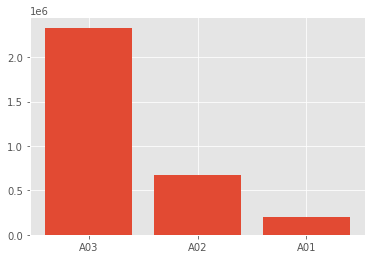

In [111]:
plt.style.use('ggplot')

fig = plt.figure()

ax = fig.add_subplot()
ax.bar(raw_data1_Online_Act['biz_unit'].unique(), raw_data1_Online_Act['biz_unit'].value_counts())

plt.show()